<a href="https://colab.research.google.com/github/leduc1234/spectral-clustering-euclidean-distance/blob/main/Spectral_clustering_euclidean_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import packages and datasets

In [2]:
!pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.9 MB 120 kB/s 


In [3]:
import os
import matplotlib.pyplot as plt
import sys
import random
import h5py
import numpy as np
import warnings
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from PIL import Image
from matplotlib import gridspec
import matplotlib.image as im
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import datatable as dtable
import os, gc, glob
import cv2
import subprocess
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

In [4]:
#go to the directory of the dataset
%cd "/content/drive/MyDrive/TRM/DAVIS 240C Dataset"  

/content/drive/MyDrive/TRM/DAVIS 240C Dataset


In [ ]:
!unzip '/content/drive/MyDrive/TRM/DAVIS 240C Dataset/shapes_rotation.zip'  

In [ ]:
#check the attributes inside the dataset
file = dtable.fread('/content/drive/MyDrive/TRM/DAVIS 240C Dataset/events.txt', sep = ' ').to_pandas()
file.columns = ['timestamp', 'x', 'y', 'polarity']
file['polarity'] *= 1
file.head()

,timestamp,x,y,polarity
0,0.000000,33,39,1
1,0.000011,158,145,1
2,0.000050,88,143,0
3,0.000055,174,154,0
4,0.000080,112,139,1


In [ ]:
#get a summary of the attributes
file.describe()

,timestamp,x,y,polarity
count,2.312629e+07,2.312629e+07,2.312629e+07,2.312629e+07
mean,3.489797e+01,1.296182e+02,9.755328e+01,4.304008e-01
std,1.571532e+01,6.579827e+01,4.848361e+01,4.951323e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.267385e+01,7.200000e+01,5.700000e+01,0.000000e+00
50%,3.651968e+01,1.360000e+02,1.020000e+02,0.000000e+00
75%,4.820719e+01,1.860000e+02,1.380000e+02,1.000000e+00
max,5.979839e+01,2.390000e+02,1.790000e+02,1.000000e+00


#Spectral clustering

Clustering algorithm adapted from 
@inproceedings{mondal2021moving,
  title={Moving Object Detection for Event-based Vision using Graph Spectral Clustering},
  author={Mondal, Anindya and Shashant, R and Giraldo, Jhony H and Bouwmans, Thierry and Chowdhury, Ananda S},
  booktitle={2021 IEEE/CVF International Conference on Computer Vision Workshops (ICCVW)},
  pages={876--884},
  year={2021},
  organization={IEEE}
}

In [ ]:
!dir #check current directory make sure to be in the dataset directory

calib.txt		    groundtruth.txt  imu.txt		  sort
DAVIS\ 240C\ Dataset.ipynb  images	     results		  video.mp4
events.txt		    images.txt	     shapes_rotation.zip


In [ ]:
import os
import matplotlib.pyplot as plt
import random
import h5py
import numpy as np
import warnings
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
print('reading davis dataset...')

#davis parameters
file = dtable.fread('/content/drive/MyDrive/TRM/DAVIS 240C Dataset/events.txt', sep = ' ').to_pandas()
file.columns = ['timestamp', 'x', 'y', 'polarity']
file['polarity'] *= 1
ts = np.array(file['timestamp'].values)
x = np.array(file['x'].values)
y = np.array(file['y'].values)
pol = np.array(file['polarity'].values)

warnings.filterwarnings('ignore', '.*Graph is not fully connected*')
ALL = len(pol)
NEIGHBORS = 30
print(str(ALL)+' events in dataset...')
seg = 1000
while seg >= 1000:
    print('dividing the sequence into '+str(seg)+' segments...')
    X = ALL//seg
    print('each segment has '+str(X)+' events, out of which '+str(X//4)+' events will be selected...')
    for sl_no in range(0,10):

        print('segment no: '+str(sl_no+1))
        selected_events = []
        for i in range(0,ALL)[sl_no*X:sl_no*X+X]:
            selected_events.append([y[i], x[i], ts[i]*0.0001, pol[i]*0])
        selected_events = np.asarray(selected_events)

        print('removing noise...')
        cleaned_events = IsolationForest(random_state=0, n_jobs=-1, contamination=0.05).fit(selected_events)
        unwanted_events = cleaned_events.predict(selected_events)
        selected_events_cleaned = selected_events[np.where(unwanted_events == 1, True, False)]

        print('constructing graph...')
        adMat_cleaned = kneighbors_graph(selected_events_cleaned, n_neighbors=NEIGHBORS)

        print('finding optimal number of clusters...')
        max_score = -20
        opt_clusters = 2
        for CLUSTERS in range(2, 10):
            clustering = SpectralClustering(n_clusters=CLUSTERS, random_state=0,
                                            affinity='precomputed_nearest_neighbors',
                                            n_neighbors=NEIGHBORS, assign_labels='kmeans',
                                            n_jobs=-1).fit_predict(adMat_cleaned)
            curr_score = silhouette_score(selected_events_cleaned, clustering)
            if curr_score > max_score:
                max_score = curr_score
                opt_clusters = CLUSTERS

        print('clustering...')
        clustering_opt = SpectralClustering(n_clusters=opt_clusters, random_state=0,
                                            affinity='precomputed_nearest_neighbors',
                                            n_neighbors=NEIGHBORS, assign_labels='kmeans',
                                            n_jobs=-1).fit_predict(adMat_cleaned)

        print('saving files...')

        yy = str(sl_no)
        file_name = yy
        os.makedirs('results/davis240/'+str(seg)+'/selected_events', exist_ok=True)
        os.makedirs('results/davis240/'+str(seg)+'/clusters', exist_ok=True)
        np.save(os.path.join('results/davis240/'+str(seg)+'/selected_events', file_name + '.npy'), selected_events_cleaned)
        np.save(os.path.join('results/davis240/'+str(seg)+'/clusters', file_name + '.npy'), clustering_opt)
    break
print('done')

reading davis dataset...
23126288 events in dataset...
dividing the sequence into 1000 segments...
each segment has 23126 events, out of which 5781 events will be selected...
segment no: 1
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 2
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 3
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 4
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 5
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 6
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 7
removing noise...
constructing graph...
finding optimal number of clusters...
c

Show selected events

1


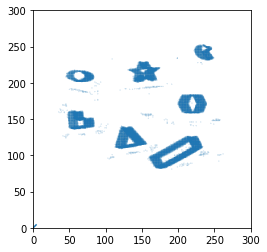

2


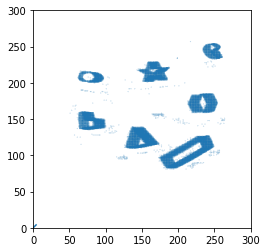

3


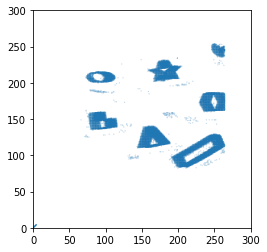

4


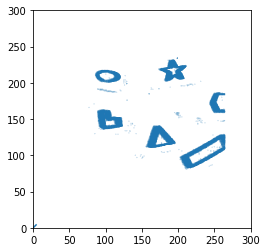

5


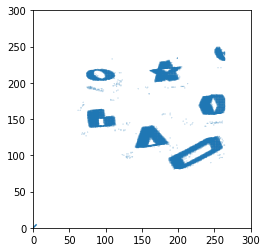

6


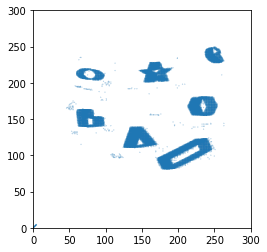

7


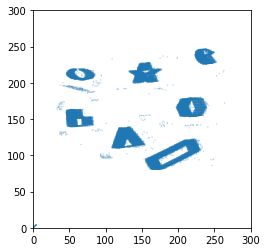

8


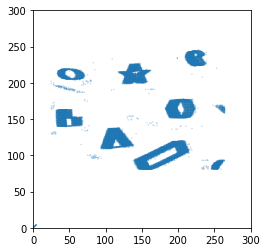

9


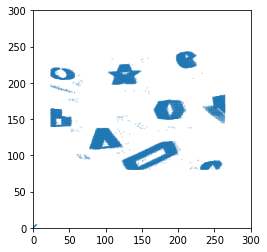

In [8]:
j=1000


for i in range(1,10):
  boxes = []


  print(i)
  yy = str(i)
  file_name = yy
  selected_events = np.load("results/davis240/"+str(j)+"/selected_events/"+file_name+".npy")
  cluster = np.load("results/davis240/"+str(j)+"/clusters/"+file_name+".npy")
  img = cv2.imread("/content/drive/MyDrive/TRM/DAVIS 240C Dataset/images/frame_00000010.png")
  #set plot axis values
  fig,ax = plt.subplots()

  ax.plot(range(5))
  plt.xlim(0, 300)
  plt.ylim(0, 300)
  plt.gca().set_aspect('equal', adjustable='box')
  x = np.array(selected_events[:, 0])
  x = 260-x
  y = np.array(selected_events[:, 1])
  y = y + 25
  z = np.array(selected_events[:, 2]*100)          

  
  plt.scatter(y,x,z)

  plt.show()

1


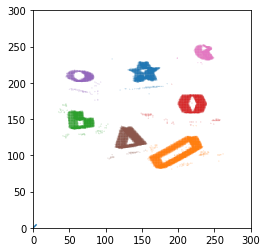

2


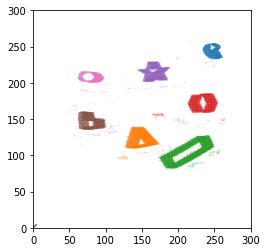

3


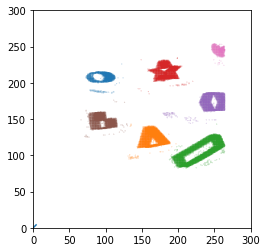

4


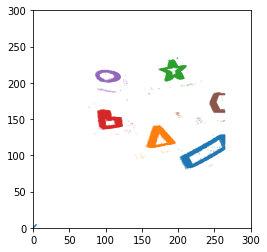

5


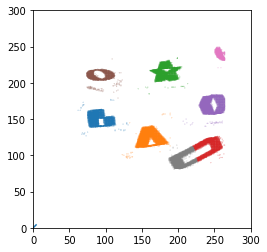

6


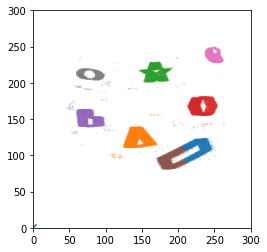

7


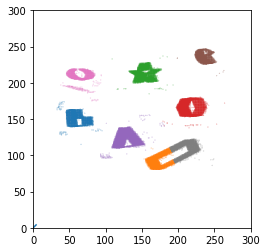

8


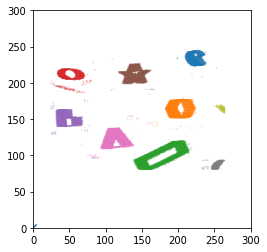

9


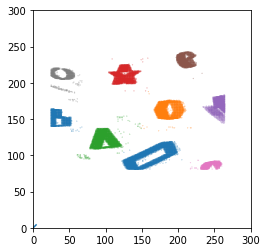

In [6]:
j=1000


for i in range(1,10):
  boxes = []


  print(i)
  yy = str(i)
  file_name = yy
  selected_events = np.load("results/davis240/"+str(j)+"/selected_events/"+file_name+".npy")
  cluster = np.load("results/davis240/"+str(j)+"/clusters/"+file_name+".npy")
  img = cv2.imread("/content/drive/MyDrive/TRM/DAVIS 240C Dataset/images/frame_00000010.png")
  #set plot axis values
  fig,ax = plt.subplots()

  ax.plot(range(5))
  plt.xlim(0, 300)
  plt.ylim(0, 300)
  plt.gca().set_aspect('equal', adjustable='box')
  x = np.array(selected_events[:, 0])
  x = 260-x
  y = np.array(selected_events[:, 1])
  y = y + 25
  z = np.array(selected_events[:, 2]*100)          

  for i in range(0,9):
   plt.scatter(y[np.where(cluster == i, True, False)], x[np.where(cluster == i, True, False)], z[np.where(cluster == i, True, False)])

  plt.show()

#Euclidean distance motion model

In [ ]:
import matplotlib.patches as patches
import math
import inspect
class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 1


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 40:
                    self.center_points[id] = (cx, cy)
                    #print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

#Spectral clustering + Euclidean distance motion model visualisation

1
[[109, 185, 76, 48, 1], [157, 81, 105, 60, 2], [35, 124, 68, 47, 3], [149, 142, 109, 56, 4], [45, 176, 48, 42, 5], [103, 95, 54, 45, 6], [199, 226, 50, 26, 7]]


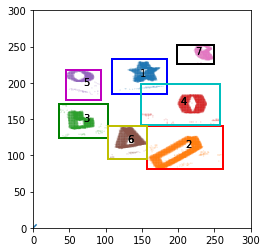

2
[[217, 222, 44, 35, 7], [115, 95, 62, 44, 6], [173, 81, 84, 60, 2], [164, 143, 100, 57, 4], [127, 185, 74, 49, 1], [51, 115, 67, 57, 3], [62, 175, 45, 41, 5]]


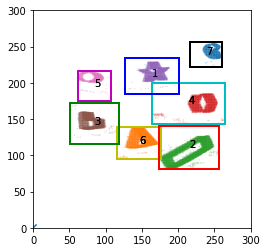

3
[[73, 186, 51, 40, 5], [131, 95, 66, 48, 6], [188, 82, 76, 61, 2], [145, 185, 75, 49, 1], [179, 144, 85, 43, 4], [66, 125, 64, 51, 3], [246, 224, 18, 30, 7]]


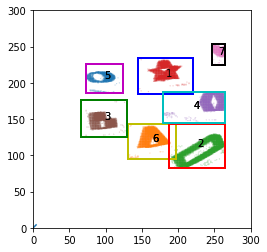

4
[[201, 81, 63, 48, 2], [141, 96, 57, 63, 6], [160, 185, 71, 49, 1], [77, 129, 63, 42, 3], [86, 176, 44, 41, 5], [198, 143, 66, 43, 4]]


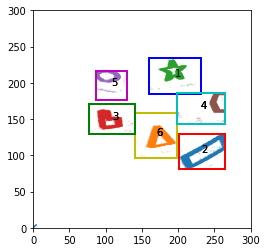

5
[[62, 127, 69, 50, 3], [123, 96, 68, 62, 6], [145, 185, 68, 49, 1], [220, 90, 44, 36, 2], [207, 140, 57, 44, 4], [74, 179, 49, 54, 5], [251, 221, 13, 28, 9]]


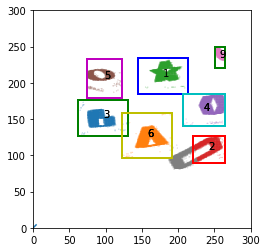

6
[[205, 88, 46, 49, 2], [107, 96, 69, 61, 6], [131, 185, 75, 49, 1], [193, 139, 70, 59, 4], [46, 115, 65, 62, 3], [169, 81, 41, 31, 10], [237, 211, 26, 38, 9], [58, 176, 55, 59, 5]]


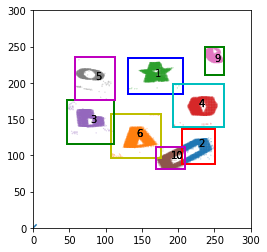

7
[[33, 115, 62, 59, 3], [153, 81, 42, 30, 10], [109, 185, 84, 52, 1], [179, 138, 85, 42, 4], [93, 96, 88, 60, 6], [199, 210, 64, 37, 9], [38, 175, 56, 44, 5], [189, 86, 60, 36, 2]]


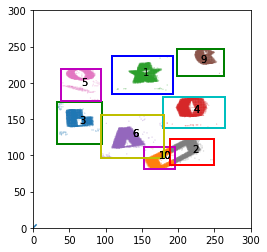

8
[[199, 208, 54, 37, 9], [161, 136, 72, 42, 4], [138, 81, 81, 39, 10], [25, 175, 60, 53, 5], [25, 129, 52, 44, 3], [108, 185, 59, 48, 1], [66, 95, 93, 59, 6], [233, 81, 31, 13, 2], [248, 158, 16, 11, 11]]


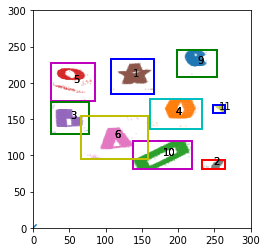

9
[[25, 81, 180, 83, 6], [149, 134, 69, 54, 4], [104, 189, 54, 45, 1], [234, 144, 30, 39, 11], [197, 206, 36, 37, 9], [217, 81, 43, 12, 2], [25, 174, 42, 46, 5]]


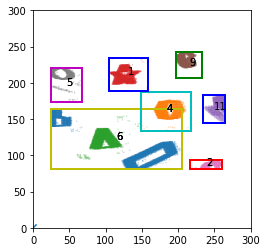

In [ ]:
j=1000


tracker = EuclideanDistTracker()

for i in range(1,10):
  boxes = []


  print(i)
  yy = str(i)
  file_name = yy
  selected_events = np.load("results/davis240/"+str(j)+"/selected_events/"+file_name+".npy")
  cluster = np.load("results/davis240/"+str(j)+"/clusters/"+file_name+".npy")
  img = cv2.imread("/content/drive/MyDrive/TRM/DAVIS 240C Dataset/images/frame_00000010.png")
  #set plot axis values
  fig,ax = plt.subplots()

  ax.plot(range(5))
  plt.xlim(0, 300)
  plt.ylim(0, 300)
  plt.gca().set_aspect('equal', adjustable='box')
  x = np.array(selected_events[:, 0])
  x = 260-x
  y = np.array(selected_events[:, 1])
  y = y + 25
  z = np.array(selected_events[:, 2]*100)

  
 # print(x[np.where(cluster == 0, True, False)])
  for i in range(0,9):
    #this for loop finds the center of each of the clusters and appends value into boxes array for euclidean class to 
    #create a unique id for each bounding box class
    small1 = -999
    small2 = 999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 > small1):
        small1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 < small2):
        small2 = ele2

    big1 = 999
    big2 = 999
    for ele3 in y[np.where(cluster == i, True, False)]:
      if(ele3 < big1):
        big1 = ele3

    for ele4 in x[np.where(cluster == i, True, False)]:
      if(ele4 < big2):
        big2 = ele4

    height1 = 999
    height2 = -999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 < height1):
        height1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 > height2):
        height2 = ele2

 #   print(small1)
#    print(small2)
 #   print(big1)
#    print(big2)
 #   print(height1)
#    print(height2)
 #   print(int(small1)-int(big1))

 #create star at the points
  #  plt.scatter(small1, small2, marker = "*", s=100, color = "black")
 #   plt.scatter(big1, big2, marker = "*", s=100, color = "black")
 #   plt.scatter(height1, height2, marker = "*", s=100, color = "black")

    #x,y top left, w = width , h = height
    width = int(small1)-int(big1)
    height = int(height2)-int(big2)
    small1 = int(small1)
    small1 = int(small2)
    big1 = int(big1)
    big2 = int(big2)
   # rect = patches.Rectangle((int(big1),int(big2)),width,height, fill=False, edgecolor='red',lw=2)

    centerx = big2 + height/2
    centery = big1 + width/2
  #  print(centerx)
  #  print(centery)
    
    


    boxes.append([int(big1), int(big2), width, height])
    
  
#update the euclidean class with current boxes
  boxes_ids = tracker.update(boxes)
  count = []
  filtered =[]
  for i in range(len(boxes_ids)):
        if(boxes_ids[i][4] not in count and boxes_ids[i][1] < 800):
            count.append(boxes_ids[i][4])
            filtered.append(boxes_ids[i])
#  print(count)
  print(filtered)
#  print(boxes_ids)

  for box_id in filtered:
            xcoord, ycoord, w, h, id = box_id
            if(id % 1 == 0):
                rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='b',lw=2)
                ax.add_patch(rect)
                plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 2 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='r',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 3 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='g',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 4 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='c',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 5 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='m',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 6 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='y',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 7 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='k',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
            if(id % 8 == 0):
              rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='purple',lw=2)
              ax.add_patch(rect)
              plt.text(xcoord+(w/2),ycoord+(h/2), id)
              

            

  for i in range(0,9):
   plt.scatter(y[np.where(cluster == i, True, False)], x[np.where(cluster == i, True, False)], z[np.where(cluster == i, True, False)])


  #plot events

 # plt.scatter(y,x,z)
  

  plt.show()

#Cluster more events

In [ ]:
import os
import matplotlib.pyplot as plt
import random
import h5py
import numpy as np
import warnings
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
print('reading davis dataset...')
#file_name = "Object Motion Data (mat files)/Cars_sequence.mat"
#f = h5py.File(file_name, "r")
#davis = f['davis']
#dvs = davis['dvs']
#pol = dvs['p'][0]
#ts = dvs['t'][0]
#x = dvs['x'][0]
#y = dvs['y'][0]

#davis parameters
file = dtable.fread('/content/drive/MyDrive/TRM/DAVIS 240C Dataset/events.txt', sep = ' ').to_pandas()
file.columns = ['timestamp', 'x', 'y', 'polarity']
file['polarity'] *= 1
ts = np.array(file['timestamp'].values)
x = np.array(file['x'].values)
y = np.array(file['y'].values)
pol = np.array(file['polarity'].values)


warnings.filterwarnings('ignore', '.*Graph is not fully connected*')
ALL = len(pol)
NEIGHBORS = 30
print(str(ALL)+' events in dataset...')
seg = 1000
while seg >= 1000:
    print('dividing the sequence into '+str(seg)+' segments...')
    X = ALL//seg
    print('each segment has '+str(X)+' events, out of which '+str(X//4)+' events will be selected...')
    for sl_no in range(24,100):

        print('segment no: '+str(sl_no+1))
        selected_events = []
        for i in range(0,ALL)[sl_no*X:sl_no*X+X]:
            selected_events.append([y[i], x[i], ts[i]*0.0001, pol[i]*0])
        selected_events = np.asarray(selected_events)

        print('removing noise...')
        cleaned_events = IsolationForest(random_state=0, n_jobs=-1, contamination=0.05).fit(selected_events)
        unwanted_events = cleaned_events.predict(selected_events)
        selected_events_cleaned = selected_events[np.where(unwanted_events == 1, True, False)]

        print('constructing graph...')
        adMat_cleaned = kneighbors_graph(selected_events_cleaned, n_neighbors=NEIGHBORS)

        print('finding optimal number of clusters...')
        max_score = -20
        opt_clusters = 2
        for CLUSTERS in range(2, 10):
            clustering = SpectralClustering(n_clusters=CLUSTERS, random_state=0,
                                            affinity='precomputed_nearest_neighbors',
                                            n_neighbors=NEIGHBORS, assign_labels='kmeans',
                                            n_jobs=-1).fit_predict(adMat_cleaned)
            curr_score = silhouette_score(selected_events_cleaned, clustering)
            if curr_score > max_score:
                max_score = curr_score
                opt_clusters = CLUSTERS

        print('clustering...')
        clustering_opt = SpectralClustering(n_clusters=opt_clusters, random_state=0,
                                            affinity='precomputed_nearest_neighbors',
                                            n_neighbors=NEIGHBORS, assign_labels='kmeans',
                                            n_jobs=-1).fit_predict(adMat_cleaned)

        print('saving files...')

        yy = str(sl_no)
        file_name = yy
        os.makedirs('results/davis240/'+str(seg)+'/selected_events', exist_ok=True)
        os.makedirs('results/davis240/'+str(seg)+'/clusters', exist_ok=True)
        np.save(os.path.join('results/davis240/'+str(seg)+'/selected_events', file_name + '.npy'), selected_events_cleaned)
        np.save(os.path.join('results/davis240/'+str(seg)+'/clusters', file_name + '.npy'), clustering_opt)
    break
print('done')

reading davis dataset...
23126288 events in dataset...
dividing the sequence into 1000 segments...
each segment has 23126 events, out of which 5781 events will be selected...
segment no: 25
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 26
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 27
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 28
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 29
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 30
removing noise...
constructing graph...
finding optimal number of clusters...
clustering...
saving files...
segment no: 31
removing noise...
constructing graph...
finding optimal number of cluste

#Silhouette score

In [ ]:
import numpy as np
import sys
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

for i in range(0, 10):
    print('img number: ', i)
    selected_events = np.load("results/davis240/1000"+"/selected_events/"+str(i) + ".npy", )
  #  print(sys.getsizeof(selected_events))
    selected_events = selected_events.astype('int32')
  #  print(sys.getsizeof(selected_events))
    clustering = np.load("results/davis240/1000"+"/clusters/"+str(i)+ ".npy")
  #  score = silhouette_score(adMat, clustering)

  #  print(silhouette_score(adMat, clustering))
    print(silhouette_score(selected_events, clustering))
  #  break

img number:  0
0.32618602943645947
img number:  1
0.6915973078129005
img number:  2
0.6888843328000956
img number:  3
0.6869090328080623
img number:  4
0.706419531735073
img number:  5
0.7036965630342829
img number:  6
0.6936886370143793
img number:  7
0.6995705317484016
img number:  8
0.6942863862124233
img number:  9
0.5193488210976718
